# Import Libraries

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset and Add headers

In [ ]:
data=pd.read_csv("/final_merged.csv")


In [ ]:
# Display the data

data.tail()


,product_id,user_id,rating,time
11127057,B01HI8V1C2,AB5HCI50SF1TK,5.0,1471305600
11127058,B01HI8V1C2,A2X11NZMPI7M0T,1.0,1470787200
11127059,B01HI8V1C2,A3EGFFBRQVO7L7,5.0,1469923200
11127060,B01HIZSSQM,A3H23AVKFN62ZT,5.0,1507161600
11127061,B01HIZSSQM,A1N6M7HRWMDE3D,5.0,1493337600


In [ ]:

#Shape of the data
data.shape
data.columns=['productId','userId','Rating','Timestamp']


(11127062, 4)

In [ ]:
#Taking subset of the dataset
electronics_data=data.iloc[:1048576,0:]

In [ ]:
#Check the datatypes
electronics_data.dtypes

productId     object
userId        object
Rating       float64
Timestamp      int64
dtype: object

In [ ]:
electronics_data.info()
len(data['user_id'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   productId  1048576 non-null  object 
 1   userId     1048576 non-null  object 
 2   Rating     1048576 non-null  float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


6801972

In [ ]:
#Five point summary

electronics_data.describe()['Rating'].T


count    1.048576e+06
mean     4.179955e+00
std      1.344108e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## Handling Missing values


In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())



Number of missing values across columns: 
 productId    0
userId       0
Rating       0
Timestamp    0
dtype: int64


## Ratings

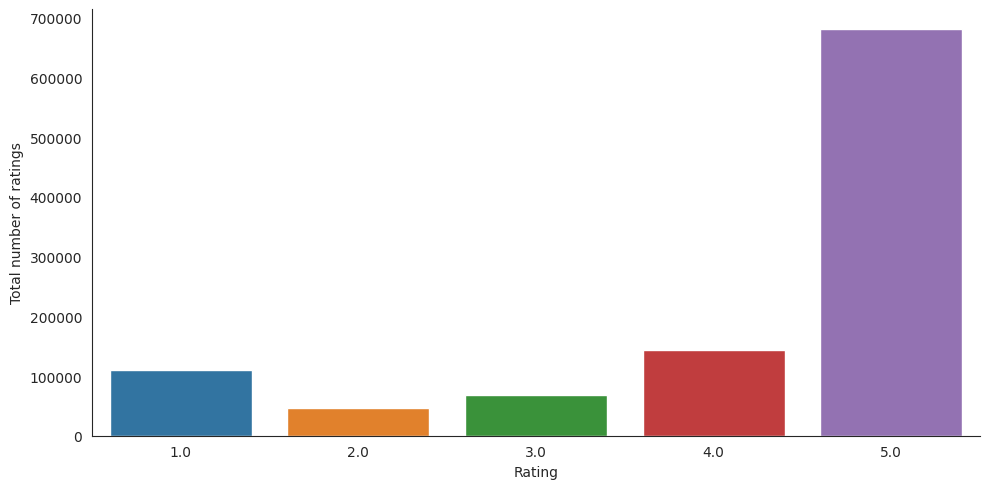

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(data=electronics_data,y=None,x='Rating' ,aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
pip install recmetrics

Most of the people has given the rating of 5

## Unique Users and products


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 889661
Total No of products  : 64253


## Dropping the TimeStamp Column

In [ ]:
#Dropping the Timestamp column

electronics_data.drop(['Timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [ ]:

#Analysis of rating given by the user

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A8WEXFRWX1ZHH     212
A21TPY9BVC9IKZ    211
A1IT56MV1C09VS    207
A2B2JVUX5YN8RU    206
A3VYM3NY7W4MX4    206
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()


count    889661.000000
mean          1.178624
std           0.906854
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         212.000000
Name: Rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

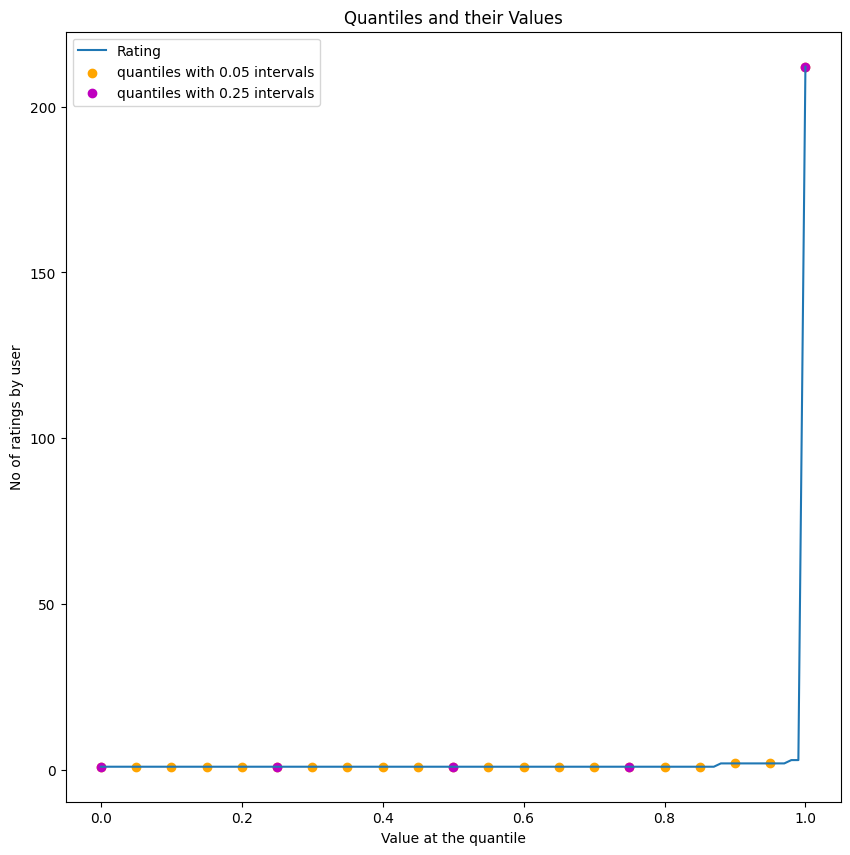

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 14



# Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

![image.png](attachment:image.png)

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, '')]

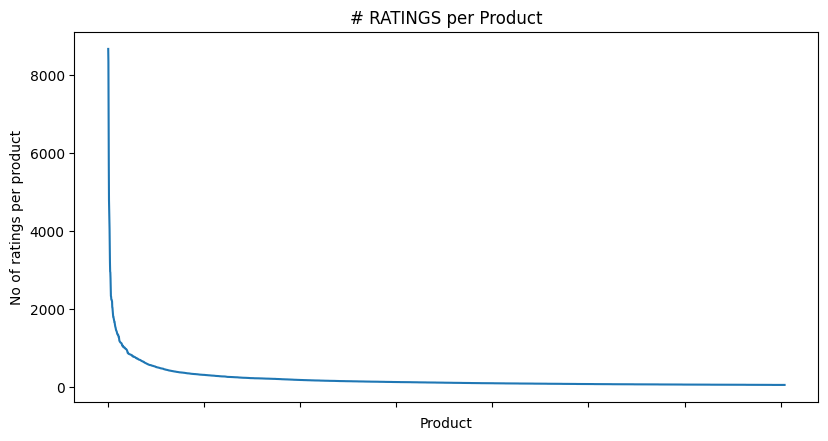

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
#Average rating of the product

new_df.groupby('productId')['Rating'].mean().head()

productId
098949232X    4.949153
1620213982    4.798414
7508492919    3.783529
7532385086    3.602740
7887421268    2.960630
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()


productId
B000KNELAW    5.000000
B0010DMNFQ    4.990446
B001EYAU88    4.987654
B004LUQRJI    4.984190
B00020UR4C    4.982571
Name: Rating, dtype: float64

In [ ]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B000FOI48G    8672
B000GLRREU    8341
B000AST3AK    6510
B004UB1O9Q    5702
1620213982    4792
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [ ]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
098949232X,4.949153,177
1620213982,4.798414,4792
7508492919,3.783529,425
7532385086,3.602740,73
7887421268,2.960630,127


In [ ]:
ratings_mean_count['rating_counts'].max()


8672

<Figure size 800x600 with 0 Axes>

<Axes: >

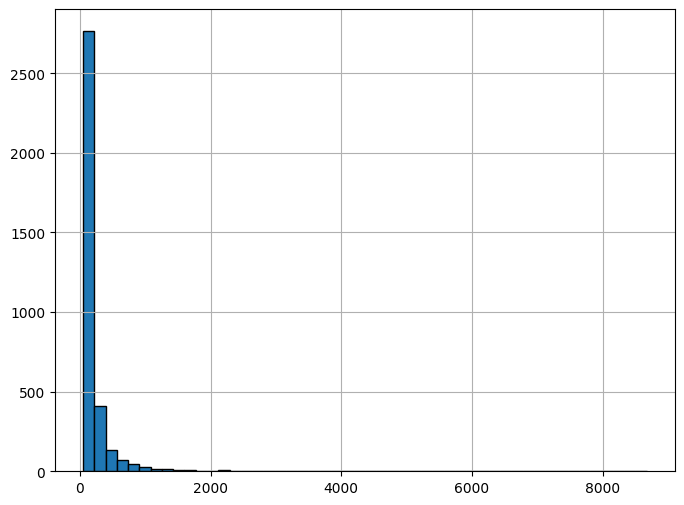

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

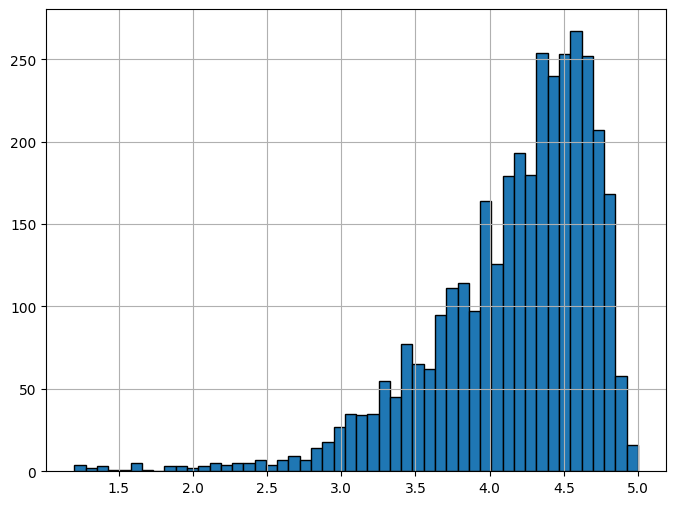

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

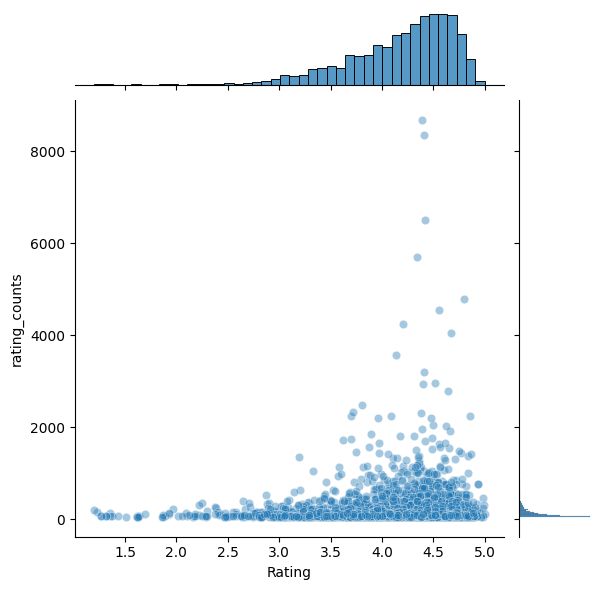

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='productId'>

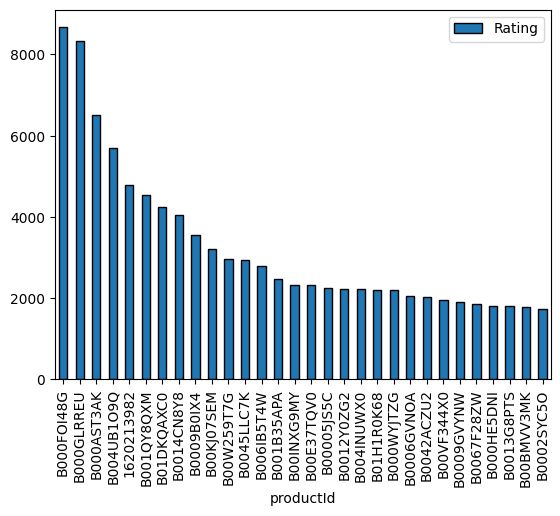

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaberative filtering (Item-Item recommedation)

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach.
CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.



In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [ ]:

new_df1=new_df.head(50000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

In [ ]:
ratings_matrix.shape


(47230, 182)

Transposing the matrix

In [ ]:
X = ratings_matrix.T
X.head()

userId,A0096681Y127OL1H8W3U,A0203113HC2KF1AHJHOV,A0324832JI7F4KRTTGDO,A035675510L7VD5NUTJS,A0486341RMMNBBGS1G4X,A0488385844WNV2OWO9X,A0611551KU79JNSC7JJV,A0647567NOSE5H95OBQ2,A0748001AYYPDBYVKQOK,A08712375GXQ4ZC4OGLE,...,AZYS0DWRRES6X,AZZ0Z2J4VBNQH,AZZ20OTK4NR3V,AZZ5U380URI57,AZZ72JCASB5WL,AZZFRROJ3HB7V,AZZM0MGLACRHJ,AZZMTAJ61KGGA,AZZS69U1WDPXV,AZZTG7HZLP2XI
productId,,,,,,,,,,,,,,,,,,,,,
1620213982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9790787006,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B6B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050B6H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000050FDT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.shape


(182, 47230)

Unique products in subset of data


In [ ]:
X1 = X


In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(182, 10)

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(182, 182)

In [ ]:
X.index[1]


'9790787006'

Index # of product ID purchased by customer



In [ ]:
i = "B000050FDT"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

4

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(182,)

Recommending
 highly correlated products in sequence



In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:15]

['B000050B6H',
 'B00009RB1I',
 'B00016WULK',
 'B000273BM0',
 'B0002JHI1I',
 'B0006M559S',
 'B0007Z8QVI',
 'B0009WY5AA',
 'B000A2LRBY',
 'B000F8JKF8',
 'B000GLRREU',
 'B000HP01UM',
 'B000IQSU0I',
 'B000NJMSXU',
 'B000NOT9GO']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.
